In [1]:
import numpy as np
from sklearn.decomposition import PCA
from nilearn import datasets, plotting, masking, image, input_data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


/home/remoteuser/neuralabc_volunteer/.local/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
#Implement the EigenGame class

import numpy as np

def calc_penalties(data, vectors, index):
    """
    calc_penalties is a helper function used by eigengame() and should never be called outside
    of it. 
    
    Parameters:
    ----------------
    :param data: (2D array), required: the data array for which we want to run PCA on.
    :param vectors: (2D array), required: the collection of eigenvectors that are being calculated by eigengame()
    :param index: (int), required: the index of the vector within vectors that we want to calculate the penalty for
    
    Returns:
    ----------------
    :returns penalties: The penalties array, which will be used by eigengame() to calculate the vector update
    References:
    ----------------
    "EigenGame: PCA as a Nash Equilibrium"; Gemp et al., 2020 
    """
    vec = vectors[:, index]
    penalties = np.zeros_like(np.dot(data, vectors[:, 0]))
    
    for i in range(index):
        result = np.dot(data, vectors[:, i])
        penalties += (np.dot(np.dot(data, vec), result) /
         np.dot(result, result)
        ) * result

    return penalties 

class EigenGame():
    def __init__(self, n_components, epochs=100, learning_rate=0.1):
        
        """
        EigenGame implements the "EigenGame" algorithm, developed by
        Gemp et al. in 2020
        
        Constructor parameters:
        ----------------
        :param data: (2D array), required: a Numpy array containing the data to run PCA on, in the form (features, samples) 
        :param n_components: (int), required: the number of principal components to extract
        :param epochs: (int), optional: the number of iterations to calculate each eigenvector. Default = 100
        :param learning_rate: (float), optional: Learning rate of the algorithm. Default = 0.1

        Returns:
        ----------------
        None

        References:
        ----------------
        "EigenGame: PCA as a Nash Equilibrium"; Gemp et al., 2020 
        """
        
        self.n_components = n_components
        self.epochs = epochs
        self.learning_rate = learning_rate
    
    def fit_transform(self, data):
        """
        fit_transform() performs PCA on input data using the "EigenGame" algorithm, developed by
        Gemp et al. in 2020

        Parameters:
        ----------------
        None
        
        Returns:
        ----------------
        vectors
        :returns vectors: the principal components, stacked horizontally

        References:
        ----------------
        "EigenGame: PCA as a Nash Equilibrium"; Gemp et al., 2020 
        """
        data = data.T
        self.data = data

        n_components = self.n_components
        learning_rate = self.learning_rate
        epochs = self.epochs
        
        dim = data.shape[1]
        vectors = np.ones((dim, n_components))
        for t in range(n_components):
            for epoch in range(epochs):
                rewards = np.dot(data, vectors[:, t])
                penalties = calc_penalties(data, vectors, t)

                delta_v = 2*np.dot(data.T, rewards - penalties)
                vectors[:, t] = vectors[:, t] + learning_rate * delta_v
                vectors[:, t] = vectors[:, t] / np.linalg.norm(vectors[:, t])

        self.eigenvectors = vectors.T
        self.components = data @ self.eigenvectors.T
        return vectors
    
    def get_explained_variance_ratio(self):
        explained_variance_ratios = []
        
        cov_matrix_firstrow = np.zeros((self.data.shape[1]))
        for i in range(self.data.shape[1]):
            cov_matrix_firstrow[i] = np.dot(self.data[:,0], self.data[:,i])
        
        
        for v in self.eigenvectors:
            explained_variance_ratios.append(np.dot(v, cov_matrix_firstrow) / v[0])
        
        covariance_matrix_trace = 0
        for row in self.data:
            covariance_matrix_trace += np.dot(row, row)
        
        return explained_variance_ratios / covariance_matrix_trace

In [3]:
#Grab one subject from the dataset
data = datasets.fetch_development_fmri(n_subjects=1)

#Calculate the mask
avg_img = image.mean_img(data.func[0])
mask = masking.compute_epi_mask(avg_img)
our_masker = input_data.NiftiMasker(mask_img=mask)

#Convert data to an array
X = our_masker.fit_transform(data['func'][0])
print(X.shape)

(168, 24256)


In [4]:
#Instantiate a PCA object from SKLearn
pca = PCA(n_components=1)

#We shall scale the data before passing it to SKLearn's PCA
scaler = StandardScaler()
X_normed = scaler.fit_transform(X)

sklearn_pca_results = pca.fit_transform(X_normed.T)

In [5]:
%%time
#Create an EigenGame object and pass our data to it

eg = EigenGame(n_components=1)
eigengame_pca_results = eg.fit_transform(X_normed.T.astype(np.float64))

CPU times: user 16.5 s, sys: 707 ms, total: 17.2 s
Wall time: 411 ms


array([[ 1.        , -0.97887198],
       [-0.97887198,  1.        ]])

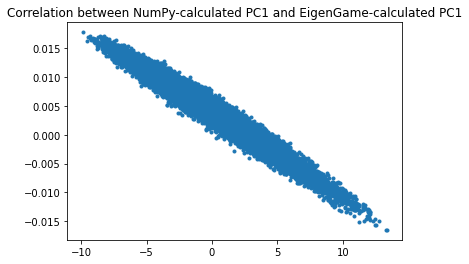

In [6]:
import matplotlib.pyplot as plt

plt.plot(sklearn_pca_results[:,0],eigengame_pca_results.reshape(-1,),'.')
plt.title("Correlation between NumPy-calculated PC1 and EigenGame-calculated PC1")
np.corrcoef(sklearn_pca_results[:,0],eigengame_pca_results.reshape(-1,))

array([[ 1.        , -0.94687302],
       [-0.94687302,  1.        ]])

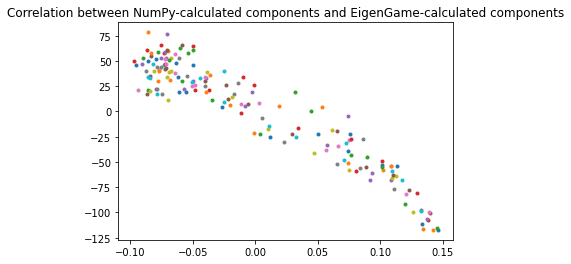

In [7]:
plt.plot(pca.components_,eg.components.T,'.')
plt.title("Correlation between NumPy-calculated components and EigenGame-calculated components")
np.corrcoef(pca.components_,eg.components.T)

In [16]:
print(" Explained variance ratio determined by EigenGame: ", eg.get_explained_variance_ratio(), "\n", 
     "Explained variance ratio determined by SKlearn's PCA: ", pca.explained_variance_ratio_)

 Explained variance ratio determined by EigenGame:  [0.10558267] 
 Explained variance ratio determined by SKlearn's PCA:  [0.07373841]
